# 0. 기본 라이브러리, 함수 Import

Pytorch에서 Tensorboard를 사용하려면 tensorboardX를 설치해야 합니다.

In [1]:
!pip install tensorboardX

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd, optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import save_image
from tensorboardX import SummaryWriter

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage
import skimage.io

torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.determinstic = False

writer = SummaryWriter(logdir='runs/DCGAN_training_5')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

1.6.0
cuda:0


dataloader 형태로 된 torch.tensor를 imshow 해주는 함수

In [4]:
def imshow_grid(img):
    img = torchvision.utils.make_grid(img.cpu().detach())
    # img = (img + 1) / 2
    img_numpy = img.numpy()
    plt.figure(figsize=(10, 20))
    plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
    plt.show()

# __GAN 훈련에 대한 부분__

# 1. Model Architecture
해당 notebook에서 각 모델을은 DCGAN을 이용한 모델입니다.

## 1-1. Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, ngf = 28, channels=1, bias = True):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf*8, kernel_size=4, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.BatchNorm2d(ngf),
            nn.ReLU(),

            nn.ConvTranspose2d(ngf, channels, kernel_size=4, stride=2, padding=1, bias=bias),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

## 1-2. Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def discriminator_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True) # Generator에 미분값을 더 잘 전달헤주기 위해 LeakyReLU 사용.
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *discriminator_block(channels, ndf, bn=False),
            *discriminator_block(ndf, ndf*2, bn=True),
            *discriminator_block(ndf*2, ndf*4, bn=True),
            *discriminator_block(ndf*4, ndf*8, bn=True)
        )

        self.last_layer = nn.Sequential(
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=bias),
            nn.Sigmoid()
        )

    def forward_features(self, x):
        features = self.features(x)
        return features

    def forward(self, x):
        features = self.forward_features(x)
        validity = self.last_layer(features)
        return validity

## 1-3. Encoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100, ndf=28, channels=1, bias=True):
        super().__init__()
        
        def encoder_block(in_features, out_features, bn=True):
            if bn:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.BatchNorm2d(out_features),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            else:
                block = [
                         nn.Conv2d(in_features, out_features, 4, 2, 1, bias=bias),
                         nn.LeakyReLU(0.2, inplace=True)
                ]
            return block

        self.features = nn.Sequential(
            *encoder_block(channels, ndf, bn=False),
            *encoder_block(ndf, ndf*2, bn=True),
            *encoder_block(ndf*2, ndf*4, bn=True),
            *encoder_block(ndf*4, ndf*8, bn=True),
            nn.Conv2d(ndf*8, latent_dim, 4, 1, 0, bias=bias),
            nn.Tanh()
        )

    def forward(self, x):
        validity = self.features(x)
        return validity

# 2. Hyper Parameters 정의

In [8]:
n_epochs = 200
batch_size = 128
lr = 0.0002
ndf = 64
workers=4
ngf = 64
latent_dim = 100
img_size = 64
channels = 3
n_critic = 5
split_rate = 0.8

# 3. Data
##3-1. Custom Data Class 정의

In [9]:
class SimpleDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.transform = transform
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = np.transpose(self.data[idx], (2, 0, 1))
        labels = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)


        return data, labels

## 3-2. Train Data, Data Loader 정의

- normal data : 1(car)
- abnormal data : 0, 2, 3, 4, 5, 6, 7, 8, 9

In [32]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
# # Train Data
# train_dataset = CIFAR10('./', train=True, download=True)

# _x_train = torch.ByteTensor(train_dataset.data[torch.IntTensor(train_dataset.targets) == 1])
# x_train, x_test_normal = _x_train.split((int(len(_x_train) * split_rate)), dim=0)

# train_dataset_target = torch.Tensor(train_dataset.targets)
# _y_train = train_dataset_target[train_dataset_target == 1]
# y_train, y_test_normal = _y_train.split((int(len(_y_train) * split_rate)), dim=0)

# train_mnist = SimpleDataset(x_train, y_train,
#                                 transform=transforms.Compose(
#                                     [transforms.ToPILImage(),
#                                      transforms.Resize(img_size),
#                                      transforms.ToTensor()])
#                                 )
# train_dataloader = DataLoader(train_mnist, batch_size=batch_size, shuffle=True)

# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#dataroot = "./dataset"

dataroot = "./dataset/data/train"
#dataroot = "./data/train"

#dataroot = "./dataset/train"
dataset = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channels),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [33]:
#print(next(ier(train_dataloader))[0].size())

In [34]:
#imshow_grid(next(iter(train_dataloader))[0])

# 4. DCGAN 학습

## 4-1. optimizer 함수, GAN 모델 정의

### 4-1-1. layer weight 초기화

CIFAR-10은 3채널 컬러 이미지이다. MNIST처럼 해상도가 낮은 gray scale이미지는 weigit initialization을 안해줘도 학습이 잘 되지만 3채널 이미지는 해주고 안해주고의 차이가 크다. (해당 함수를 사용 할때와 안할때를 한번 비교해보세요)

In [35]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [36]:
G = Generator(latent_dim = latent_dim, ngf=ngf, channels=channels, bias=False).to(device)
G.apply(weights_init)
D = Discriminator(ndf=ndf, channels=channels, bias=False).to(device)
D.apply(weights_init)

optimizer_G = optim.Adam(G.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, weight_decay=1e-5, betas=(0.5, 0.999))

## 4-2. DCGAN Training

### 4-2-1. Watching Tensor Board

아래 내용들은 Colab과 같은 notebook 형식에서 Tensorboard를 확인하는 방법입니다.

In [37]:
%load_ext tensorboard
%tensorboard --logdir runs --port=5000

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 5000 (pid 4762), started 0:40:13 ago. (Use '!kill 4762' to kill it.)

### 4-2-2. Training

In [38]:
padding_epoch = len(str(n_epochs)) #3
padding_i = len(str(len(train_dataloader))) # 2

d_losses = []
g_losses = []

criterion = nn.BCELoss()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

        fake_imgs = G(z)

        real_validity = D(real_imgs)
        fake_validity = D(fake_imgs.detach())
        
        # Adversarial loss
        d_loss_real = criterion(real_validity, torch.ones_like(real_validity).to(device))
        d_loss_fake = criterion(fake_validity, torch.zeros_like(fake_validity).to(device))
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        
        optimizer_D.step()
        
        if i % n_critic == 0:
            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()
            
            fake_imgs = G(z)
            fake_validity = D(fake_imgs)

            g_loss = criterion(fake_validity, torch.ones_like(fake_validity).to(device))

            g_loss.backward()
            optimizer_G.step()
            
            d_losses.append(d_loss)
            g_losses.append(g_loss)

            writer.add_scalars('DCGAN loss', {'G_loss': g_loss.item(), 'D_loss': d_loss.item()}, epoch)
            
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                f"[D loss: {d_loss.item():3f}] "
                f"[G loss: {g_loss.item():3f}]")
print('Finished Training')


Finished Training


### 4-2-3. matplotlib를 이용해서 loss 그려보기.

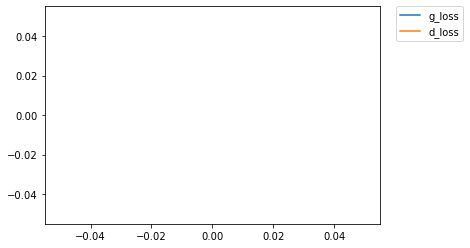

In [39]:
plt.plot(g_losses, label='g_loss')
plt.plot(d_losses, label='d_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 4-2-4. Normal Fake Image 출력해보기.


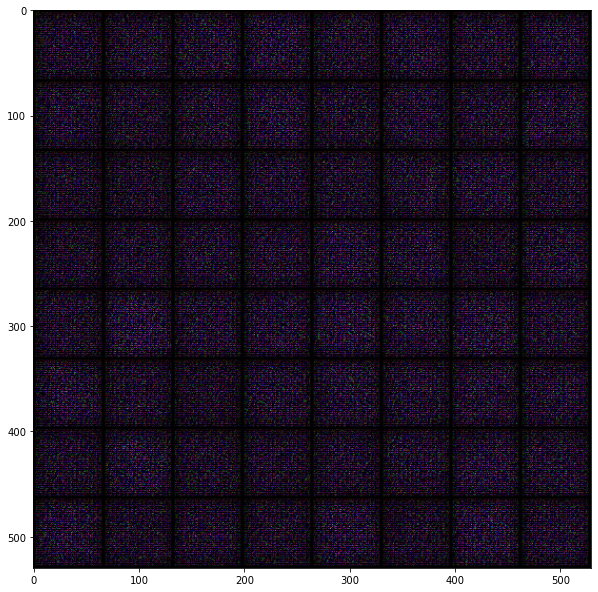

In [40]:
z = torch.randn(64, latent_dim, 1, 1).to(device)
imshow_grid(G(z))

# 5. Encoder izif 훈련

In [41]:
writer = SummaryWriter(logdir='runs/Encoder_training')

E = Encoder(latent_dim, ndf, channels, bias=False).to(device)
E.apply(weights_init)

G.eval()
D.eval()

criterion = nn.MSELoss()

optimizer_E = torch.optim.Adam(E.parameters(), lr=lr, betas=(0.0, 0.999))

padding_epoch = len(str(n_epochs))
padding_i = len(str(len(train_dataloader)))
kappa = 1.0
e_losses = []

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(train_dataloader):
        real_imgs = imgs.to(device)
        
        optimizer_E.zero_grad() 
        z = E(real_imgs)
        
        fake_imgs = G(z)

        real_features = D.forward_features(real_imgs)
        fake_features = D.forward_features(fake_imgs)

        # izif architecture
        loss_imgs = criterion(fake_imgs, real_imgs)
        loss_features = criterion(fake_features, real_features)
        e_loss = loss_imgs + kappa * loss_features

        e_loss.backward()
        optimizer_E.step()


        if i % n_critic == 0:
            e_losses.append(e_loss)

            writer.add_scalar('e_loss', e_loss.item(), epoch)
            print(f"[Epoch {epoch:{padding_epoch}}/{n_epochs}] "
                    f"[Batch {i:{padding_i}}/{len(train_dataloader)}] "
                    f"[E loss: {e_loss.item():3f}]")
            
#writer.close()
print('Finished Training')

Finished Training


## 5-1. Encoder를 이용한 mapping된 latent vector를 이용해서 fake image 확인


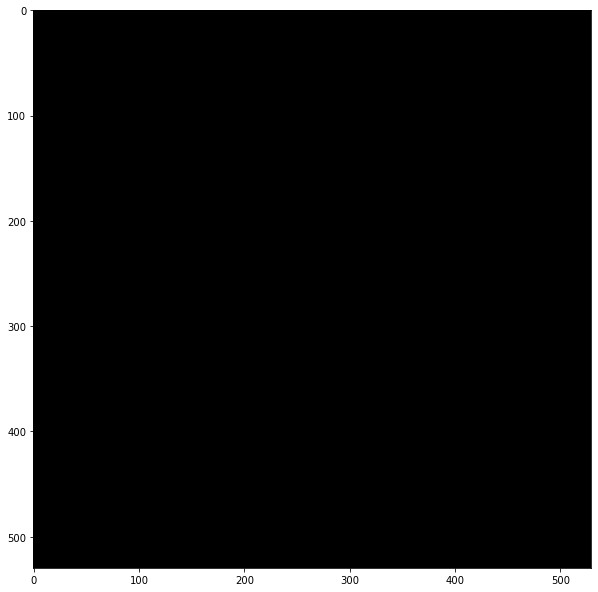

In [42]:
z = torch.randn(64, latent_dim, 1, 1).to(device) # 64, 100
fake_imgs = G(z) # 64, 1, 28, 28
fake_z = E(fake_imgs) #64, 100
reconfiguration_imgs = G(fake_z)

imshow_grid(reconfiguration_imgs)

# 6. 최종 결과 확인

## 6-1. Test Data Load
- normal data : 1(car)
- abnormal data : 1(car)을 제외한 나머지 숫자 값

In [76]:
dataroot = "./dataset/data/test"
#dataroot = "./data/train"

#dataroot = "./dataset/train"
test_mnist = dset.ImageFolder(root = dataroot,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channels),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))



# Test DAta
#test_dataset = CIFAR10('./', train=False, download=False)

#x_test = torch.cat([x_test_normal[:10], train_dataset.data[train_dataset.targets != 1], test_dataset.data], dim=0)[:20]
#y_test = torch.cat([y_test_normal[:10], train_dataset.targets[train_dataset.targets != 1], test_dataset.targets], dim=0)[:20]
#x_test = torch.cat([x_test_normal, torch.ByteTensor(train_dataset.data[torch.IntTensor(train_dataset.targets) != 1]), torch.ByteTensor(test_dataset.data)], dim=0)
#y_test = torch.cat([y_test_normal, train_dataset_target[train_dataset_target != 1], torch.FloatTensor(test_dataset.targets)], dim=0)

# test_mnist = SimpleDataset(x_test, y_test,
#                             transform=transforms.Compose(
#                             [transforms.ToPILImage(),
#                             transforms.Resize(64),
#                             transforms.ToTensor()])
#                             )

test_dataloader = DataLoader(test_mnist, batch_size=1, shuffle=True)

In [77]:
def compare_images(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = np.transpose(real_img.cpu().data.numpy().squeeze(), (1, 2, 0))
    real_img = real_img.reshape(64, 64, 3)
    generated_img = np.transpose(generated_img.cpu().data.numpy().squeeze(), (1, 2, 0))
    generated_img = generated_img.reshape(64, 64, 3)

    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    anomaly_img = [np.zeros(shape=(64, 64, 3)), np.zeros(shape=(64, 64, 3)), np.zeros(shape=(64, 64, 3))]
    anomaly_img[0] = (real_img - diff_img) * 255
    anomaly_img[1] = (real_img - diff_img) * 255
    anomaly_img[2] = (real_img - diff_img) * 255
    anomaly_img[0] = anomaly_img[0] + diff_img

    anomaly_img = [anomaly_img[0].astype(np.uint8), anomaly_img[1].astype(np.uint8), anomaly_img[2].astype(np.uint8)]

    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(20)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='bone', label='real')
    plots[1].imshow(generated_img, cmap='bone')
    plots[2].imshow(diff_img, cmap='bone')
    plots[3].imshow(anomaly_img[0], cmap='bone')

    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

0, 0.01220755185931921, 0.012214044108986855, 2.249094541184604e-05



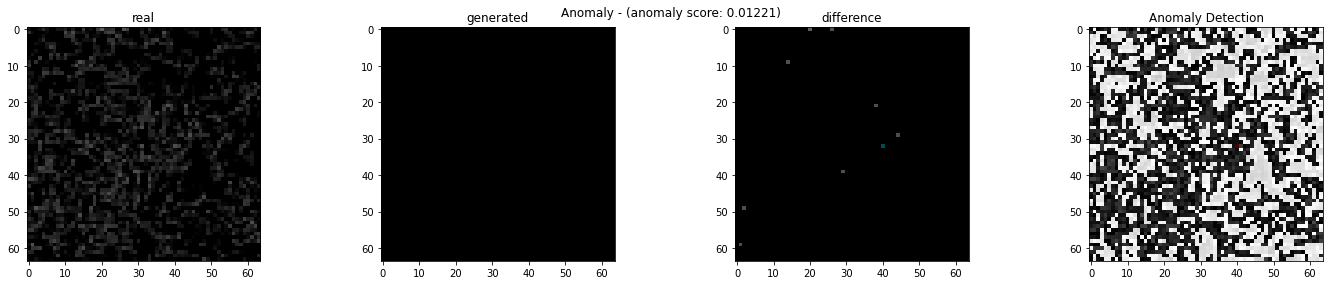

In [85]:
criterion = nn.MSELoss()
G.eval()
D.eval()
E.eval()

with open("score.csv", "w") as f:
        f.write("label,img_distance,anomaly_score,z_distance\n")

for i, (img, label) in enumerate(test_dataloader):
    real_img = img.to(device)

    real_z = E(real_img) # 진짜 이미지의 latent vector
    fake_img = G(real_z) # G에 넣어서 가짜 이미지 생성.
    fake_z = E(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    real_feature = D.forward_features(real_img) # 1, 256
    fake_feature = D.forward_features(fake_img)

    img_distance = criterion(fake_img, real_img)
    loss_feature = criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = criterion(fake_z, real_z)
    
    with open("score.csv", "a") as f:
            f.write(f"{label.item()},{img_distance},"
                    f"{anomaly_score},{z_distance}\n")

    if i % 500 == 0:
        print(f"{label.item()}, {img_distance}, "
          f"{anomaly_score}, {z_distance}\n")
        compare_images(real_img, fake_img,i, anomaly_score, reverse = False, threshold = 0.3)



In [64]:
a = [np.zeros((224,224,3)), np.zeros((224,224,3)), np.zeros((10,224,3))]
np.array(a).shape

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


(3,)

# 7. Visualization

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc

In [66]:
df = pd.read_csv("score.csv")
df

label  img_distance  anomaly_score  z_distance
0      0      0.160776       0.160872    0.000331
1      0      0.032263       0.032281    0.000046
2      0      0.056501       0.056532    0.000105
3      0      0.084460       0.084526    0.000157
4      0      0.154338       0.154431    0.000313
5      0      0.093435       0.093499    0.000170
6      0      0.012208       0.012214    0.000022

In [67]:
trainig_label = 1
labels = np.where(df["label"].values == trainig_label, 0, 1) # 라벨이 1이면 0을 반환, 아니면 1을 반환.
anomaly_score = df["anomaly_score"].values
img_distance = df["img_distance"].values
z_distance = df["z_distance"].values

In [68]:
fpr, tpr, _ = roc_curve(labels, img_distance)
precision, recall, _ = precision_recall_curve(labels, img_distance)
roc_auc = auc(fpr, tpr)
pr_auc =  auc(recall, precision)

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


## 7-1. Image-level anomaly detection accuracy evaluation

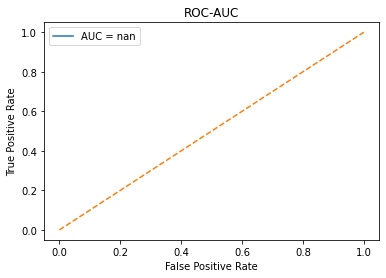

In [69]:
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

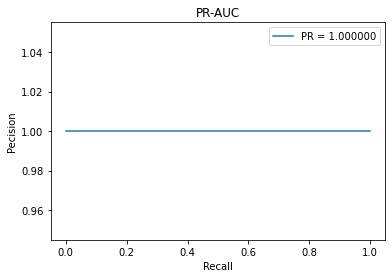

In [70]:
plt.plot(recall, precision, label=f"PR = {pr_auc:3f}")
plt.title("PR-AUC")
plt.xlabel("Recall")
plt.ylabel("Pecision")
plt.legend()
plt.show()

## 7-2. Discrete distributions of anomaly scores

/home/piai/anaconda3/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


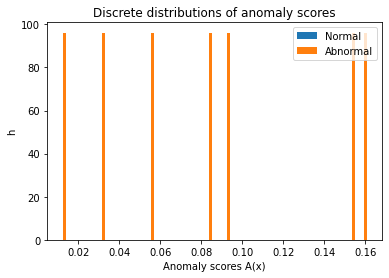

In [71]:
plt.hist([anomaly_score[labels == 0], anomaly_score[labels == 1]],
          bins=100, density=True, stacked=True,
          label=["Normal", "Abnormal"])
plt.title("Discrete distributions of anomaly scores")
plt.xlabel("Anomaly scores A(x)")
plt.ylabel("h")
plt.legend()
plt.show()